In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt

rf_rate = 0.046

#### General information:

Modern Portfolio Theory (MPT), a hypothesis put forth by Harry Markowitz in his paper "Portfolio Selection," (published in 1952 by the Journal of Finance) is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize or maximize expected return based on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.



**ALPHA:** Alpha is used for mutual funds and all types of investments. It is often represented as a single number (like 3 or -5), but this refers to a percentage measuring how the portfolio or fund performed compared to the benchmark index (i.e. 3% better or 5% worse). Alpha is often used in conjunction with the beta, which measures volatility or risk. Alpha is also often referred to as “excess return” or “abnormal rate of return.”


**BETA:** Beta (aka Beta Coefficient) is a measure of the volatility, or systematic risk, of a security or a portfolio in comparison to the market as a whole. Beta is used in the capital asset pricing model (CAPM), which calculates the expected return of an asset based on its beta and expected market returns.
- A beta of 1 indicates that the security's price moves with the market. A beta of less than 1 means that the security is theoretically less volatile than the market. A beta of greater than 1 indicates that the security's price is theoretically more volatile than the market.

How we interpreted BETA: 
- week 1: we took the beta's that where higher than the market beta (HIGHER volatility compared to )

## Data: 

In [198]:
# data: 
file_location = r'D:\studie\main_studie\files\asset_pricing\assignments_assetpricing\trading_game\data\week4\trading-game-data-21112023.xlsx'

# Trading game Data:
xls_dict  = pd.read_excel(file_location, sheet_name=None)

info_df = xls_dict['info'][['Ticker', 'RBICS Economy']]
info_df = info_df.set_index('Ticker')

index_price_df = xls_dict['index-price']
index_price_df['Date'] = pd.to_datetime(index_price_df['Date'])
index_price_df.set_index('Date', inplace=True)

price_df = xls_dict['price'].reset_index()
price_df = price_df.drop('index', axis = 1)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)
price_df = price_df.drop(['VLTO','KVUE'], axis = 1)

size_df = xls_dict['size']
price_to_book_df = xls_dict['price-to-book']
turnover_df = xls_dict['turnover']

In [199]:
# LOG return: 
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns

daily_logreturns = calcualte_logreturns(price_df)
monthly_logreturns = calcualte_logreturns(price_df.asfreq('M', method='ffill'))
anual_logreturns = daily_logreturns * 250

daily_SP500_logreturns = calcualte_logreturns(index_price_df['S&P 500'])
monthly_SP500_logreturns = calcualte_logreturns(index_price_df['S&P 500'].asfreq('M', method='ffill'))
annual_sp500_logreturns = daily_SP500_logreturns * 250 

In [4]:
# ESG data: 
esg_data_path = r"D:\studie\main_studie\files\asset_pricing\assignments_assetpricing\trading_game\data\esg data.csv"
esgratings_df = pd.read_csv(esg_data_path)
esgratings_df = esgratings_df[['Symbol', 'Sector', 'Total ESG Risk score']]
sector_medians = esgratings_df.groupby(esgratings_df['Sector']).median()

esgratings_df.set_index('Symbol', inplace=True)
esgratings_df = esgratings_df.T

full_esg_df = pd.DataFrame(index=info_df.index)
full_esg_df['ESG Score'] = np.nan  # Initialize all scores as NaN

# Iterate over all companies in the S&P 500
for company in full_esg_df.index:
    if company in esgratings_df.index:
        # Use the actual ESG score if available
        full_esg_df.loc[company, 'ESG Score'] = esgratings_df.loc[company, 'Total ESG Risk score']
    else:
        # Retrieve the sector from info_df
        sector = info_df.loc[company, 'RBICS Economy']
        # Use the sector median if the sector is available
        if sector in sector_medians.index:
            full_esg_df.loc[company, 'ESG Score'] = sector_medians.loc[sector, 'Total ESG Risk score']

# Handling cases where the sector is unknown or no median is available
full_esg_df['ESG Score'].fillna(full_esg_df['ESG Score'].median(), inplace=True)
full_esg_df['Inverted_ESG'] = -full_esg_df['ESG Score']

In [5]:
# FF model:
momentum_df = pd.read_csv('data/' + 'F-F_Momentum_Factor_daily.CSV')
factors_df = pd.read_csv('data/' + 'F-F_5factors_daily.CSV')

momentum_df.columns = ['Date', 'Momentum']
factors_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factors_df = factors_df.merge(momentum_df, on='Date')
factors_df = factors_df.rename(columns={"Unnamed: 0": "Date"})
factors_df['Date'] = pd.to_datetime(factors_df['Date'], format='%Y%m%d')
factors_df.set_index('Date', inplace=True)
factors_df.to_parquet('ff_momentum.par')

## CAPM Model: (Week 1)

In [6]:
def calc_CAPM_betas(daily_returns, sp_500_daily_returns):
    """
    Calculate the CAPM beta values for the stocks in the daily_returns DataFrame.
    """
    
    # Join the daily returns of the stocks with the S&P 500 daily returns
    daily_returns_with_sp500 = daily_returns.join(sp_500_daily_returns.rename('SP500'))
    
    # Calculate the covariance matrix of the returns
    cov_matrix_with_sp500 = daily_returns_with_sp500.cov()
    
    # The market variance is the variance of the S&P 500 returns
    market_var = sp_500_daily_returns.var()
    
    # Calculate the betas for each stock
    betas = cov_matrix_with_sp500.loc[:, 'SP500'] / market_var
    betas = betas.drop(['SP500'], axis=0)
    return betas

betas = calc_CAPM_betas(daily_logreturns, daily_SP500_logreturns)

#### EXAMPLE: 
https://blog.quantinsti.com/modern-portfolio-capital-asset-pricing-fama-french-three-factor-model/?signuptype=google


In [10]:

stocks_list = daily_logreturns.columns
num_stocks = len(stocks_list)

cov_daily = daily_logreturns.cov()
cov_annual = anual_logreturns.cov()

port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

num_combination_portfolios = 100

for single_portfolio in range(num_combination_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    returns = np.dot(weights, anual_logreturns.mean())
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(stocks_list):
    #portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]
    portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

C:\Users\bramg\AppData\Local\Temp\ipykernel_8700\3189456833.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


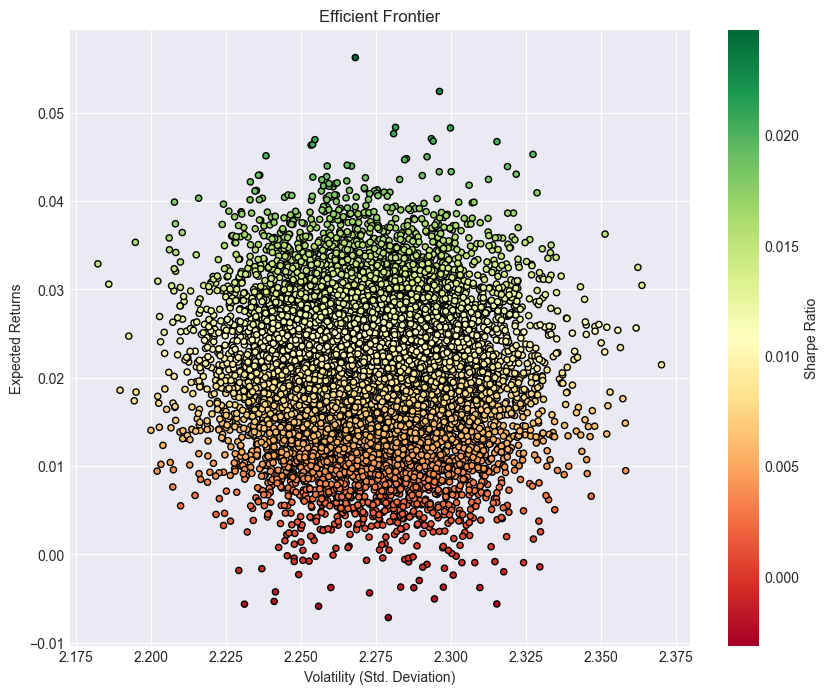

C:\Users\bramg\AppData\Local\Temp\ipykernel_8700\3189456833.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


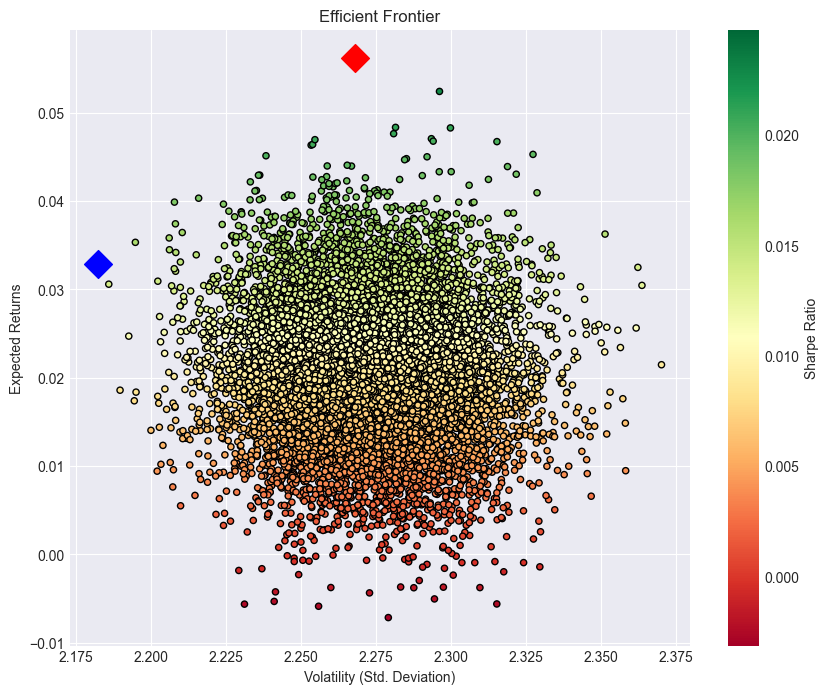

TWO PORTFOLIOS WITH MAX SHARPE RATIO AND MIN VOLATILITY
                      4401
Returns       3.287421e-02
Volatility    2.182310e+00
Sharpe Ratio  1.506395e-02
A             1.874009e-03
AAL           1.261358e-04
...                    ...
YUM           3.104687e-03
ZBH           2.922770e-03
ZBRA          1.107288e-07
ZION          2.623787e-03
ZTS           3.928672e-03

[503 rows x 1 columns]
                  6816
Returns       0.056218
Volatility    2.268088
Sharpe Ratio  0.024787
A             0.003240
AAL           0.000999
...                ...
YUM           0.001368
ZBH           0.003286
ZBRA          0.001789
ZION          0.000742
ZTS           0.002849

[503 rows x 1 columns]


In [54]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()
# print the details of the 2 special portfolios

print("TWO PORTFOLIOS WITH MAX SHARPE RATIO AND MIN VOLATILITY")
print(min_variance_port.T)
print(sharpe_portfolio.T)

## FAMA French (week 2,3,4)

In [14]:
factors_df

,Mkt-RF,SMB,HML,RMW,CMA,RF,Momentum
Date,,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012,-0.21
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012,0.42
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012,0.41
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012,0.07
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012,-0.45
...,...,...,...,...,...,...,...
2023-09-25,0.39,-0.07,0.35,0.59,-0.46,0.021,0.13
2023-09-26,-1.46,0.35,-0.50,-0.36,-0.08,0.021,0.39
2023-09-27,0.13,0.78,0.12,0.18,-0.27,0.021,1.16


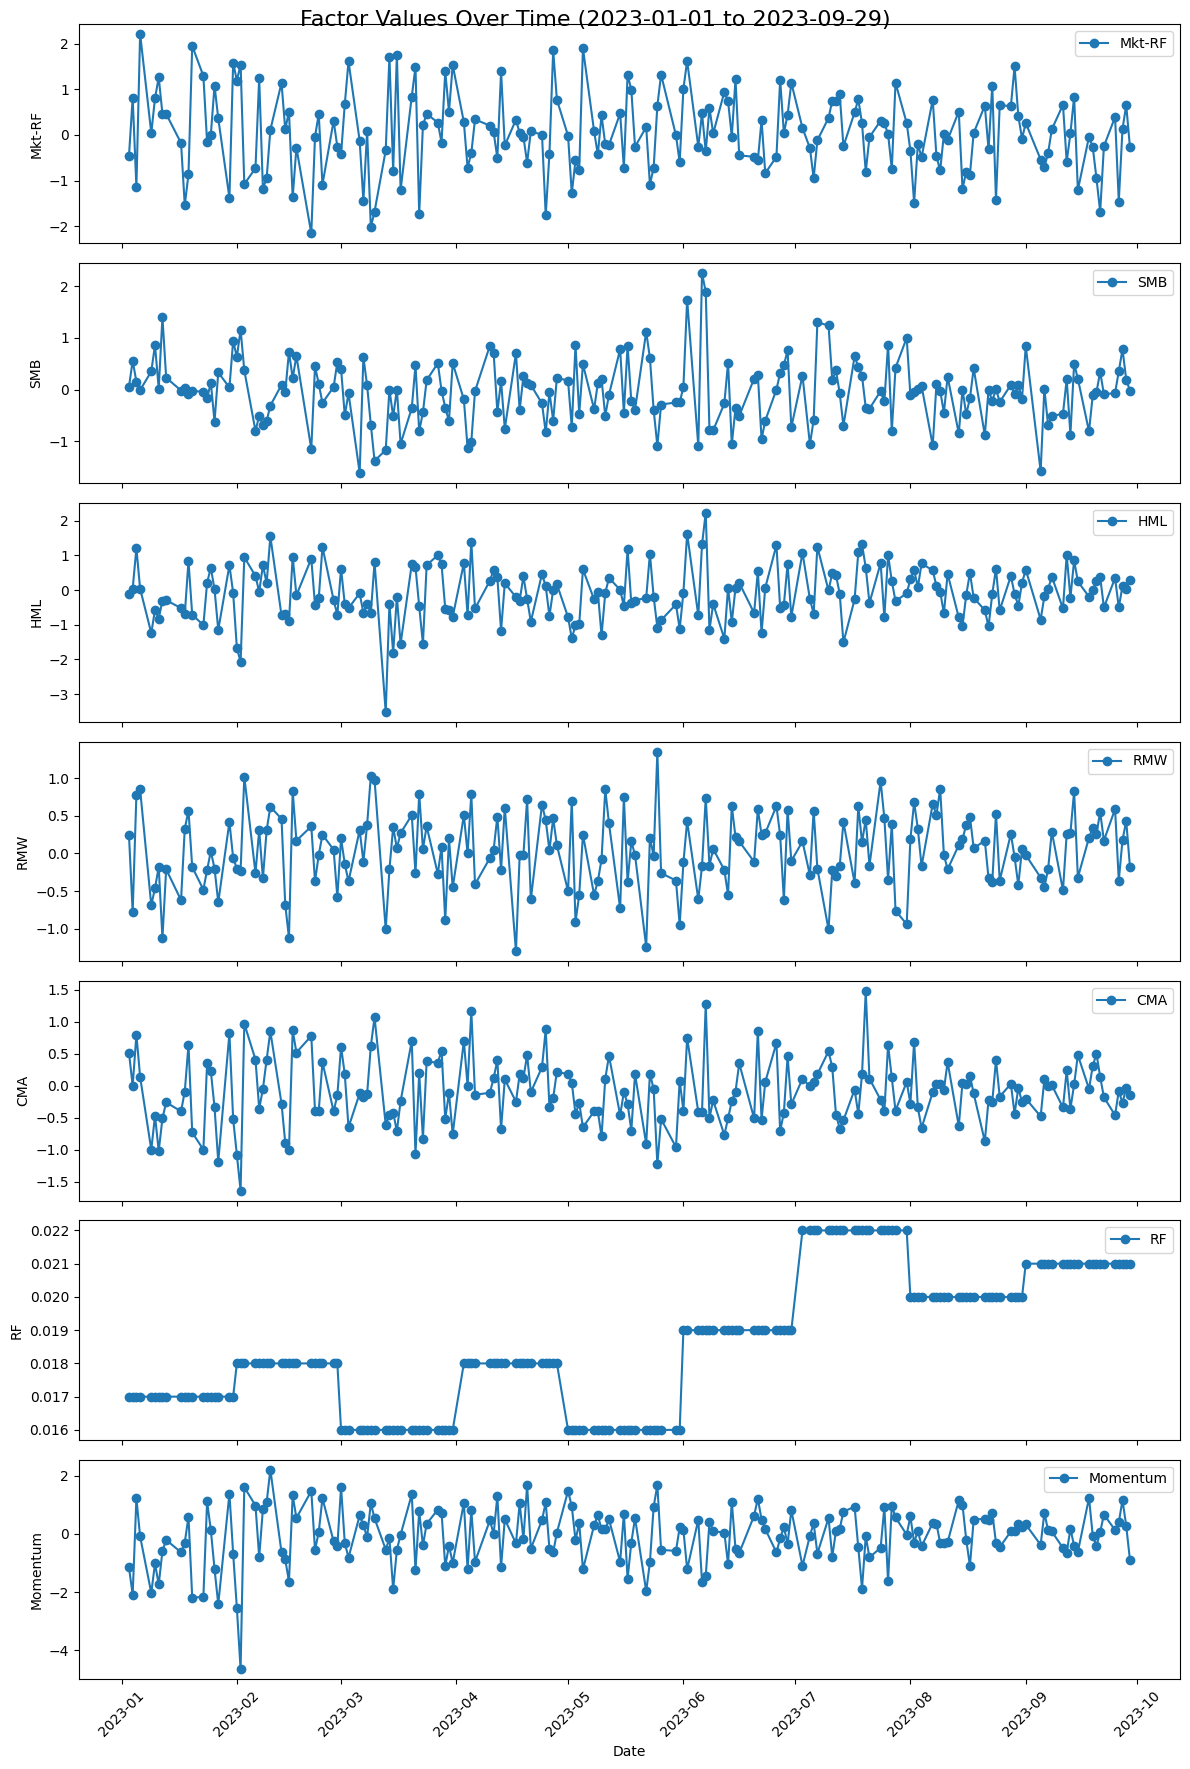

In [20]:
start_date = '2023-01-01'
end_date = '2023-09-29'
filtered_df = factors_df[(factors_df.index >= start_date) & (factors_df.index <= end_date)]

# Create a figure with 7 subplots (one for each factor)
fig, axes = plt.subplots(7, 1, figsize=(12, 18), sharex=True)

# Define a list of factor names
factor_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Momentum']

# Loop through each factor and create a subplot
for i, factor in enumerate(factor_names):
    ax = axes[i]
    ax.plot(filtered_df.index, filtered_df[factor], label=factor, linestyle='-', marker='o')
    ax.set_ylabel(factor)
    ax.legend()

# Set common x-axis label and title
axes[-1].set_xlabel('Date')
plt.suptitle('Factor Values Over Time (2023-01-01 to 2023-09-29)', fontsize=16)

# Rotate x-axis labels for better readability (optional)
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust subplot spacing
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
# Efficient frontier: 
# https://blog.quantinsti.com/modern-portfolio-capital-asset-pricing-fama-french-three-factor-model/

factors_df

# FF french: model
# CAPM model
# Efficient frontier


# Diversification: look at correlation coefficient
# 

,Mkt-RF,SMB,HML,RMW,CMA,RF,Momentum
Date,,,,,,,
1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012,-0.21
1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012,0.42
1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012,0.41
1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012,0.07
1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012,-0.45
...,...,...,...,...,...,...,...
2023-09-25,0.39,-0.07,0.35,0.59,-0.46,0.021,0.13
2023-09-26,-1.46,0.35,-0.50,-0.36,-0.08,0.021,0.39
2023-09-27,0.13,0.78,0.12,0.18,-0.27,0.021,1.16


## Stock valuation: 

In [23]:
import requests

def get_esterdata():
    API_KEY = 'Jcu52w5Gpb+4VrQI58md/A==lPpZWr0GtZ9GlZzg'
    api_url = 'https://api.api-ninjas.com/v1/interestrate'
    response = requests.get(api_url, headers={'X-Api-Key': API_KEY}).json()

    ester_rate_pct = None
    for item in response["non_central_bank_rates"]:
        if item["name"] == "ESTER":
            ester_rate_pct = item["rate_pct"]/100
    return ester_rate_pct

rf_rate = get_esterdata()

In [114]:
import statsmodels.api as sm

def calc_CAPM_betas(daily_returns, market_returns):
    """
    Calculate the CAPM beta values for the stocks in the daily_returns DataFrame using regression.
    """
    betas = {}
    errors = {}

    excess_return = daily_returns.subtract(rf_rate, axis=0) #expected excess return of the stock
    excess_return_market = market_returns.subtract(rf_rate) #excess return of the market portfolio index

    combined_returns = excess_return.join(excess_return_market.rename('S&P 500'))
    
    for stock in excess_return.columns:
        X = sm.add_constant(combined_returns['S&P 500'])
        y = combined_returns[stock]
        model = sm.OLS(y, X).fit()
        beta = model.params[1]
        betas[stock] = beta
        errors[stock] = model.resid
    betas = pd.Series(betas)
    errors = pd.Series(errors)

    return betas, excess_return, errors

returns = price_df.pct_change().dropna()
returns
sp500_returns = index_price_df['S&P 500'].pct_change().dropna()
betas, excess_return, model_errors = calc_CAPM_betas(daily_returns=returns, market_returns=sp500_returns)

def fama_macbeth_regression(betas, excess_returns): 
    X = sm.add_constant(betas)
    y = excess_returns
    model = sm.OLS(y,X).fit()
    return model.summary()

average_excess_return = excess_return.mean()
fama_macbeth_regression(betas, average_excess_return)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.39
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           1.34e-08
Time:                        15:16:15   Log-Likelihood:                 2665.0
No. Observations:                 498   AIC:                            -5326.
Df Residuals:                     496   BIC:                            -5317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0394      0.000   -300.201      0.000      -0.040      -0.039
0              0.0007      0.000      5.778      0.000       0.000       0.001
==============================================================================
Omnibus:                       45.747   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.290
Skew:                          -0.322   Prob(JB):                     2.86e-37
Kurtosis:                       5.774   Cond. No.                         4.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

def extendFFcoefficients():
    def test_stationarity(timeseries):
        dftest = adfuller(timeseries, autolag = 'AIC')
        return dftest[1]

    df = factors_df.drop('RF', axis = 1).copy()
    last_date = df.index[-1]
    required_last_date = daily_logreturns.index[-1]

    new_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), end=required_last_date, freq='B')
    n_forecast_steps = len(new_dates)

    for column in df.columns: 
        if test_stationarity(df[column]) > 0.05:
            df[column] = df[column].diff().dropna()

    model = VAR(df)
    lag_order = model.select_order(maxlags=120)
    optimal_lag = lag_order.selected_orders['aic']
    fitted_model = model.fit(optimal_lag)
    forecasted_values = fitted_model.forecast(df.values[-optimal_lag:], steps=n_forecast_steps)
    forecasted_df = pd.DataFrame(forecasted_values, columns=df.columns)
    forecasted_df.index = new_dates

forecasted_df = pd.read_parquet('forecasted_VAR.par')
forecasted_df['Market_Risk_Premium'] = sp500_returns.subtract(rf_rate)

## Prospect Theory: 
Based on our findings, we propose a Seven-Factor asset pricing model merging the insights of Expected Utility Theory, and Prospect Theory. Our new model explains variations in asset returns more comprehensively than the CAPM and its extensions including the recently established five factor CAPM by Fama and French (2015).


In [214]:
beta_data = pd.DataFrame(index=daily_logreturns.columns, columns=['Beta_MKT', 'Beta_SMB', 'Beta_HML'])

for stock_symbol in daily_logreturns.columns:
    stock_returns = daily_logreturns[stock_symbol]
    regression_data = pd.concat([stock_returns, forecasted_df[['SMB','HML']]], axis=1).dropna()
    regression_data['Market_Risk_Premium'] = sp500_returns.subtract(rf_rate)
    regression_data = sm.add_constant(regression_data)
    model = sm.OLS(regression_data[stock_symbol], regression_data[['const', 'Market_Risk_Premium', 'SMB', 'HML']])
    results = model.fit()
    beta_mkt, beta_smb, beta_hml = results.params[['Market_Risk_Premium', 'SMB', 'HML']]
    beta_data.loc[stock_symbol] = [beta_mkt, beta_smb, beta_hml]

A
AAL
AAPL
ABBV
ABNB
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALK
ALL
ALLE
AMAT
AMCR
AMD
AME
AMGN
AMP
AMT
AMZN
ANET
ANSS
AON
AOS
APA
APD
APH
APTV
ARE
ATO
ATVI
AVB
AVGO
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBWI
BBY
BDX
BEN
BF.B
BG
BIIB
BIO
BK
BKNG
BKR
BLK
BMY
BR
BRK.B
BRO
BSX
BWA
BX
BXP
C
CAG
CAH
CARR
CAT
CB
CBOE
CBRE
CCI
CCL
CDAY
CDNS
CDW
CE
CEG
CF
CFG
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTLT
CTRA
CTSH
CTVA
CVS
CVX
CZR
D
DAL
DD
DE
DFS
DG
DGX
DHI
DHR
DIS
DLR
DLTR
DOV
DOW
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
ENPH
EOG
EPAM
EQIX
EQR
EQT
ES
ESS
ETN
ETR
ETSY
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FLT
FMC
FOXA
FRT
FSLR
FTNT
FTV
GD
GE
GEHC
GEN
GILD
GIS
GL
GLW
GM
GNRC
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HCA
HD
HES
HIG
HII
HLT
HOLX
HON
HPE
HPQ
HRL
HSIC
HST
HSY
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
ILMN
INCY
INTC

In [215]:
beta_data

,Beta_MKT,Beta_SMB,Beta_HML
A,0.896419,0.002706,0.000426
AAL,1.207195,0.010814,-0.000867
AAPL,1.094805,-0.000557,-0.003661
ABBV,0.266653,-0.003962,0.004087
ABNB,1.570683,0.005022,-0.003589
...,...,...,...
YUM,0.624774,-0.002261,0.001427
ZBH,0.633929,-0.000762,0.000532
ZBRA,1.500775,0.011849,-0.003285
ZION,2.415161,0.012827,0.030275


In [238]:
risk_free_rate = rf_rate
expected_returns_df = pd.DataFrame(index=daily_logreturns.index, columns=daily_logreturns.columns)

for date in daily_logreturns.index:
    market_risk_premium = forecasted_df.loc[date, 'Market_Risk_Premium']
    smb = forecasted_df.loc[date, 'SMB']
    hml = forecasted_df.loc[date, 'HML']
    
    expected_returns = (
        risk_free_rate
        + (beta_data['Beta_MKT'] * market_risk_premium)
        + (beta_data['Beta_SMB'] * smb)
        + (beta_data['Beta_HML'] * hml)
    )
    
    expected_returns_df.loc[date] = expected_returns

In [282]:
from sklearn.ensemble import RandomForestRegressor

num_portfolios = 100
portfolio_weights = np.random.rand(num_portfolios, len(expected_returns))
portfolio_weights /= portfolio_weights.sum(axis=1, keepdims=True)  # Ensure weights sum to 1
portfolio_weights = np.array(portfolio_weights, dtype=np.float64)

# Calculate portfolio returns and portfolio variances
portfolio_returns = np.dot(portfolio_weights, expected_returns)
cov_matrix = daily_logreturns.cov()
portfolio_variances = np.array([np.dot(np.dot(weights, cov_matrix), weights.T) for weights in portfolio_weights])

# # Calculate Sharpe ratios for each portfolio
risk_free_rate = 0.03  # Adjust with your actual risk-free rate
sharpe_ratios = (portfolio_returns - risk_free_rate) / np.sqrt(portfolio_variances)

# # Create a DataFrame with features (returns, variances, Sharpe ratios) and labels (portfolio weights)
portfolio_data = pd.DataFrame({'Returns': portfolio_returns, 'Variances': portfolio_variances, 'Sharpe_Ratio': sharpe_ratios})
# Create a DataFrame with features (returns, variances, Sharpe ratios) and labels (portfolio weights)
portfolio_data = pd.DataFrame({'Returns': portfolio_returns, 'Variances': portfolio_variances, 'Sharpe_Ratio': sharpe_ratios})

# Train a random forest regression model to predict portfolio weights based on features
features = portfolio_data[['Returns', 'Variances', 'Sharpe_Ratio']]
labels = portfolio_weights  # Assign portfolio_weights directly as labels
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features, labels)
predicted_weights = rf_model.predict(features.values)
sorted_portfolios = portfolio_data.copy()
sorted_portfolios['Predicted_Weights'] = predicted_weights.tolist()
sorted_portfolios = sorted_portfolios.sort_values(by='Predicted_Weights', ascending=False)
sorted_portfolios

C:\Users\bramg\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


,Returns,Variances,Sharpe_Ratio,Predicted_Weights
7,0.008249,0.000083,-2.393937,"[0.003607080120382403, 0.001566621302373998, 0..."
61,0.008135,0.000083,-2.395233,"[0.0034330300184973535, 0.0024779886293019053,..."
37,0.008336,0.000083,-2.3777,"[0.0034327253461807344, 0.0012184108892482955,..."
24,0.008223,0.000083,-2.392925,"[0.0034180965571216676, 0.0011492516255980272,..."
22,0.007399,0.000087,-2.42098,"[0.0032907451325618277, 0.0009830248123852041,..."
...,...,...,...,...
83,0.008298,0.000082,-2.39636,"[0.0008216168788824131, 0.0015470992055728724,..."
62,0.008264,0.000082,-2.40577,"[0.000771960602840037, 0.0021203309379907065, ..."
1,0.008468,0.000083,-2.362534,"[0.0007577444747488289, 0.001174243445708604, ..."
71,0.008485,0.000082,-2.372872,"[0.0007460169788154453, 0.0016095342102068777,..."


In [287]:
sorted_portfolios['Predicted_Weights'][0].sort_values()

AttributeError: 'list' object has no attribute 'sort_values'

In [281]:
sorted_portfolios

,Returns,Variances,Sharpe_Ratio,Predicted_Weights
70,0.008353,0.000082,-2.392124,"[0.003620370065241046, 0.0012431802379675747, ..."
88,0.007963,0.000084,-2.404714,"[0.0035576821941204232, 0.0018729199736282835,..."
3,0.008105,0.000083,-2.40658,"[0.0035061584662030697, 0.002663635026748789, ..."
72,0.008177,0.000082,-2.406994,"[0.0034406539454565244, 0.001810373188914253, ..."
12,0.008364,0.000082,-2.389983,"[0.003435079811610492, 0.0004476841615604426, ..."
...,...,...,...,...
1,0.008581,0.000082,-2.372551,"[0.0009162453008312603, 0.0019195038307656003,..."
84,0.008113,0.000083,-2.395892,"[0.0008556917414866556, 0.0009353850184246901,..."
82,0.007698,0.000086,-2.401306,"[0.0008396826520447425, 0.001179741270556525, ..."
59,0.0084,0.000082,-2.382049,"[0.0007260454242235524, 0.0018061071590362568,..."


## Backtesting
- Sensitivity analysis
- ??

In [ ]:
# Backtesting: 
# https://blog.quantinsti.com/backtesting/


